# Detecting languages, translating and assessing sentiment of 163.668 climate change twits.
### Bonus: Geo-visualisation of twits with registered coordinates.

In [1]:
# Setting up the environment with the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import re # regular expression library for text cleaning
from wordcloud import WordCloud
import json
from time import sleep
from langdetect import detect
from googletrans import Translator, LANGUAGES
import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar to monitor the progress of long running loops
import folium
from folium.plugins import MarkerCluster

In [2]:
# Set pandas display options to show full text
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 200)

# Download required NLTK data
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/josepescrivasavall/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/josepescrivasavall/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

As the dataset contains tweets in different languages, the first step is to detect the languages and translate them into English to ensure accurate analysis.

In [3]:
# Translating and cleaning non-English and English tweets...
# Initialize the translator
translator = Translator()

def detect_language(text):
    if not isinstance(text, str) or not text.strip():
        return 'en'
    try:
        return detect(text)
    except:
        return 'en'

def translate_text(text, source_lang):
    if source_lang == 'en':
        return text
    
    try:
        for attempt in range(3):
            try:
                translated = translator.translate(text, src=source_lang, dest='en')
                if translated and translated.text and translated.text != text:
                    return translated.text
            except Exception as e:
                if attempt < 2:
                    sleep(1)
                    continue
                else:
                    print(f"Translation error: {str(e)}")
                    break
    except Exception as e:
        print(f"Unexpected error: {str(e)}")
    
    return text

def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'RT', '', text)
        text = ' '.join(text.split()).lower()  # Convert to lowercase for consistency
    return text

# Load the data
df = pd.read_csv('data/Dataset.csv')

# Print the first few rows of the DataFrame to verify the data
print("Loading data...")
print(df.head())

# First detect languages
tqdm.pandas(desc="Detecting languages")
df['lang'] = df['text'].progress_apply(detect_language)

# Print available languages
print(LANGUAGES)

# Filter non-English tweets
non_english_mask = df['lang'] != 'en'
print(f"Found {non_english_mask.sum()} non-English tweets")

# Translate and clean non-English tweets
tqdm.pandas(desc="Translating and cleaning non-English tweets")
df.loc[non_english_mask, 'cleaned_text'] = df.loc[non_english_mask].progress_apply(
    lambda row: clean_text(translate_text(row['text'], row['lang'])), axis=1
)

# Clean English tweets
tqdm.pandas(desc="Cleaning English tweets")
df.loc[~non_english_mask, 'cleaned_text'] = df.loc[~non_english_mask]['text'].progress_apply(clean_text)

print("Text processing completed")
# Save the processed DataFrame to a new CSV file
print("Processed data saved to 'data/text_processed.csv'...")
df.to_csv('data/text_processed.csv', index=False)

# Print the head of non-English tweets with original text, detected language, and cleaned_text
non_english_tweets = df.loc[non_english_mask]
print("Head of non-English tweets:")
print(non_english_tweets[['text', 'lang', 'cleaned_text']].head())
print(df[['text', 'lang', 'cleaned_text']].head())

Loading data...
   Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0                   id  \
0             0           0.0           0.0           0.0         0.0  1028954403129184256   
1             1           1.0           1.0           1.0         1.0  1028954356572250112   
2             2           2.0           2.0           2.0         2.0  1028954497341480960   
3             3           3.0           3.0           3.0         3.0  1028954494133043200   
4             4           4.0           4.0           4.0         4.0  1028954811511844864   

                                                                                                                                               text  favorite_count  retweet_count  \
0                                                                                                     Gotta love the facts. https://t.co/bZ2G8AZuo9               0              0   
1  RT @ToolangiForest: A great day of action for our me

Detecting languages: 100%|██████████| 163669/163669 [10:24<00:00, 262.22it/s]


{'af': 'afrikaans', 'sq': 'albanian', 'am': 'amharic', 'ar': 'arabic', 'hy': 'armenian', 'az': 'azerbaijani', 'eu': 'basque', 'be': 'belarusian', 'bn': 'bengali', 'bs': 'bosnian', 'bg': 'bulgarian', 'ca': 'catalan', 'ceb': 'cebuano', 'ny': 'chichewa', 'zh-cn': 'chinese (simplified)', 'zh-tw': 'chinese (traditional)', 'co': 'corsican', 'hr': 'croatian', 'cs': 'czech', 'da': 'danish', 'nl': 'dutch', 'en': 'english', 'eo': 'esperanto', 'et': 'estonian', 'tl': 'filipino', 'fi': 'finnish', 'fr': 'french', 'fy': 'frisian', 'gl': 'galician', 'ka': 'georgian', 'de': 'german', 'el': 'greek', 'gu': 'gujarati', 'ht': 'haitian creole', 'ha': 'hausa', 'haw': 'hawaiian', 'iw': 'hebrew', 'he': 'hebrew', 'hi': 'hindi', 'hmn': 'hmong', 'hu': 'hungarian', 'is': 'icelandic', 'ig': 'igbo', 'id': 'indonesian', 'ga': 'irish', 'it': 'italian', 'ja': 'japanese', 'jw': 'javanese', 'kn': 'kannada', 'kk': 'kazakh', 'km': 'khmer', 'ko': 'korean', 'ku': 'kurdish (kurmanji)', 'ky': 'kyrgyz', 'lo': 'lao', 'la': 'lat

Translating and cleaning non-English tweets:  88%|████████▊ | 5137/5837 [49:39<25:38,  2.20s/it]  

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating and cleaning non-English tweets:  88%|████████▊ | 5146/5837 [50:06<37:40,  3.27s/it]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating and cleaning non-English tweets:  88%|████████▊ | 5147/5837 [50:09<38:11,  3.32s/it]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating and cleaning non-English tweets:  93%|█████████▎| 5413/5837 [54:32<09:27,  1.34s/it]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Cleaning English tweets: 100%|██████████| 157832/157832 [00:02<00:00, 69134.15it/s]


Text processing completed
Processed data saved to 'data/text_processed.csv'...
Head of non-English tweets:
                                                                                                                                             text lang  \
151                                                                                   Suçlu hep küresel ısınma(!) zaten.. https://t.co/VU7BweZASF   tr   
188             RT @PrysorWilliams: Farmers - please complete and RT! \nFfermwyr - cwblhewch ac aildrydarwch hwn, ogydda! https://t.co/oRhVdhprtA   cy   
190             RT @PrysorWilliams: Farmers - please complete and RT! \nFfermwyr - cwblhewch ac aildrydarwch hwn, ogydda! https://t.co/oRhVdhprtA   cy   
196                RT @Convecarne: Como los veganos están equivocados acerca del ganado y del cambio climático. En ingles https://t.co/ZPic4PCSca   es   
294  @mrurbano @jennymaria Det är en sammandragning av ”klimatförändringsförnekare”, som är en direktöversättning av eng… h

## Sentiment analysis
The VADER (Valence Aware Dictionary and sEntiment Reasoner) is employed as a lexicon and rule-based sentiment analysis tool, as it is specifically designed to analyse sentiments expressed on social media.

Calculating sentiment scores: 100%|██████████| 163669/163669 [00:38<00:00, 4271.06it/s]


Sentiment scores saved to 'data/sentiment_scores.csv'...


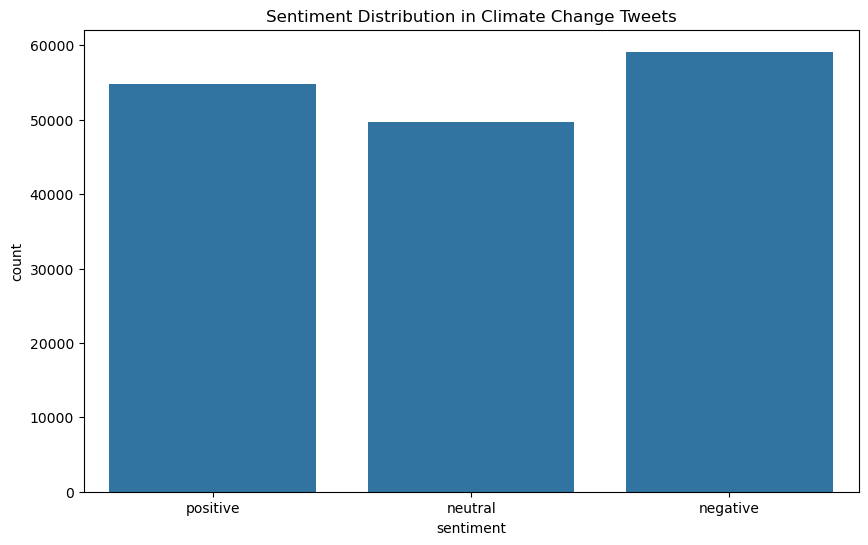

Sentiment Distribution (%):
sentiment
negative    36.137570
positive    33.504818
neutral     30.357612
Name: proportion, dtype: float64


In [4]:


# Load the processed data
df = pd.read_csv('data/text_processed.csv')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Get sentiment scores with handling for non-string values
def get_sentiment_score(text):
    if pd.isna(text) or not isinstance(text, str):
        return 0  # neutral score for missing or non-string values
    return sia.polarity_scores(text)['compound']

tqdm.pandas(desc="Calculating sentiment scores")
df['sentiment_scores'] = df['cleaned_text'].progress_apply(get_sentiment_score)


# Convert scores to sentiment categories
df['sentiment'] = df['sentiment_scores'].apply(lambda x: 
    'positive' if x > 0.05 
    else 'negative' if x < -0.05 
    else 'neutral')

# store the sentiment scores and sentiment categories in a new CSV file
print("Sentiment scores saved to 'data/sentiment_scores.csv'...")
df.to_csv('data/sentiment_scores.csv', index=False) 

# Visualize results
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment')
plt.title('Sentiment Distribution in Climate Change Tweets')
plt.show()

# Calculate percentage distribution
sentiment_dist = df['sentiment'].value_counts(normalize=True) * 100
print("Sentiment Distribution (%):")
print(sentiment_dist)

Let’s take a look at a sample of the top 10 publishers by AVG engagement score.
- The engagement score is the sum of favourites (weighted) and retweets of each mentioned account.

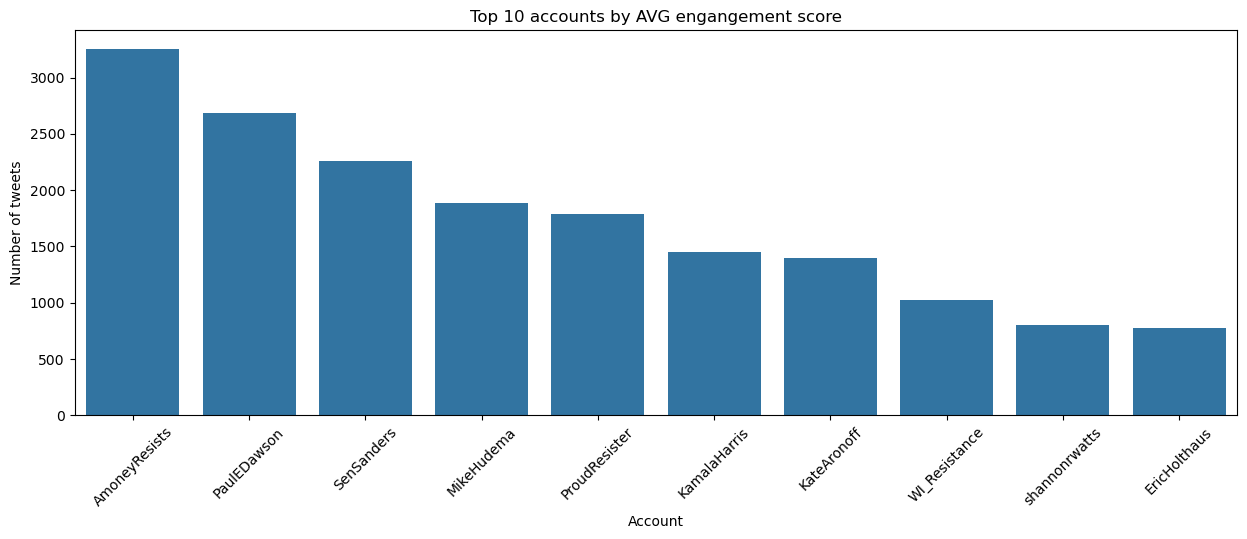

In [5]:
# Load the data
df = pd.read_csv('data/sentiment_scores.csv')
# Identify the different accounts publishing the tweets
# scrape the account names from the text column
df['account'] = df['text'].str.extract(r'@(\w+)')
# Calculate engagement score (favorites weighted x500 plus retweets)
df['engagement'] = (df['favorite_count'] * 500) + df['retweet_count']
# Count the number of tweets per account
account_counts = df['account'].value_counts()
# Calculate average engagement score for each account
account_engagement = df.groupby('account').agg({
    'engagement': 'mean'
}).fillna(0)

# Sort accounts by average engagement
account_engagement = account_engagement.sort_values('engagement', ascending=False)
# Making top 10 accounts
top_accounts = account_counts.head(10)
# Plot the top 10 accounts
plt.figure(figsize=(15, 5))
sns.barplot(x=top_accounts.index, y=top_accounts.values)
plt.xticks(rotation=45)
plt.title('Top 10 accounts by AVG engangement score')
plt.xlabel('Account')
plt.ylabel('Number of tweets')
plt.show() # The plot shows the top 10 accounts publishing the tweets


Here are the top three tweets from each of the top ten accounts.

In [6]:
# Top 3 tweets of each top 10 accounts with the most liked and retweeted tweets
top_tweets = pd.DataFrame()
for account in top_accounts.index:
    # Filter the tweets of the current account
    account_tweets = df[df['account'] == account]
    
    # Remove duplicate tweets by checking the text content
    account_tweets = account_tweets.drop_duplicates(subset=['text'])
    
    # Add an engagement score column (favorites weighted x500 plus retweets)
    account_tweets['engagement'] = (account_tweets['favorite_count'] * 500) + account_tweets['retweet_count']
    
    # Get top 3 tweets by engagement
    top_tweets = pd.concat([top_tweets, account_tweets.nlargest(3, 'engagement')])

# Sort by engagement score in descending order
top_tweets['engagement_score'] = (top_tweets['favorite_count'] * 500) + top_tweets['retweet_count'] # multiply favorites by 500 to add more weight
top_tweets = top_tweets.sort_values('engagement_score', ascending=False)

# Display the top tweets with formatted columns
display_tweets = top_tweets[['account', 'sentiment', 'text', 'favorite_count', 'retweet_count', 'engagement_score']]
display_tweets.columns = ['Account', 'Sentiment', 'Text', 'Likes', 'Retweets', 'Engagement Score']
display_tweets = display_tweets.reset_index(drop=True)
print("\nTop Tweets by Engagement Score:")
print(display_tweets)


Top Tweets by Engagement Score:
          Account Sentiment                                                                                                                                                    Text  Likes  Retweets  \
0    EricHolthaus  positive                             @EricHolthaus Yes, absolutely, on the hike and talking about climate change - and what we can and must do. Will DM you now.    807        24   
1      SenSanders  negative            .@SenSanders criticized @SecretaryZinke for saying the California wildfires have nothing to do with climate change;… https://t.co/DMyVhMzWHx    119        44   
2    EricHolthaus   neutral             @EricHolthaus @Jen_Kotila I took this pic of Lake Josephine in @GlacierNPS in 2015. Above is Grinnell Glacier, one… https://t.co/w4wixhyz5R     55        21   
3      SenSanders  positive            RT @SenSanders: "You say you love your children above all else, yet you are stealing their futures right before their very eyes,

Let’s visualise the word clouds for each category.

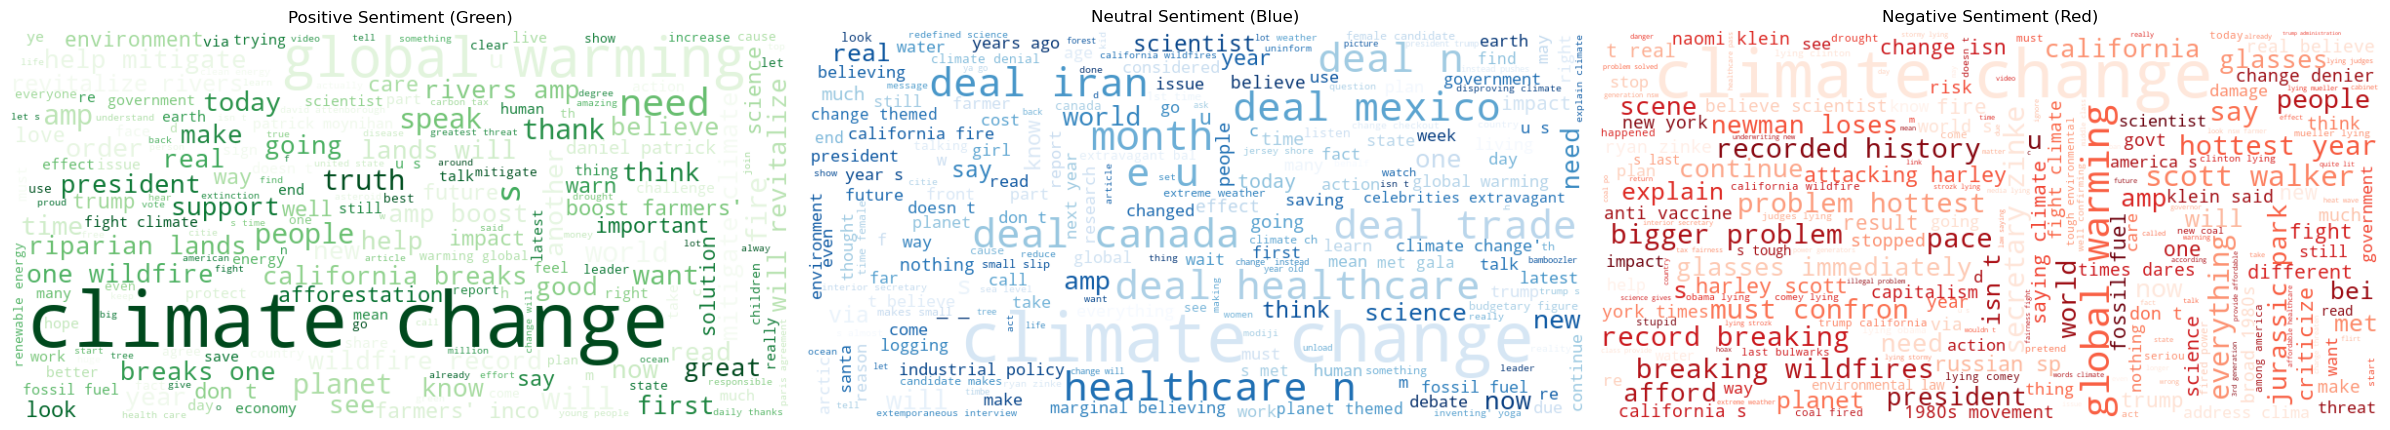

In [7]:
# Add this check before joining tweets
def safe_join(text_series):
    # Filter out non-string values and convert to string
    return ' '.join(str(text) for text in text_series if isinstance(text, str))
# Combine text for each sentiment category
positive_tweets = df[df['sentiment'] == 'positive']['cleaned_text']
positive_text = safe_join(positive_tweets)

negative_tweets = df[df['sentiment'] == 'negative']['cleaned_text']
negative_text = safe_join(negative_tweets)

neutral_tweets = df[df['sentiment'] == 'neutral']['cleaned_text']
neutral_text = safe_join(neutral_tweets)

# Generate word clouds for each sentiment category
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(neutral_text)

# Display the word clouds side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Positive sentiment word cloud
axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title('Positive Sentiment (Green)')
axes[0].axis('off')

# Neutral sentiment word cloud
axes[1].imshow(neutral_wordcloud, interpolation='bilinear')
axes[1].set_title('Neutral Sentiment (Blue)')
axes[1].axis('off')

# Negative sentiment word cloud
axes[2].imshow(negative_wordcloud, interpolation='bilinear')
axes[2].set_title('Negative Sentiment (Red)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


To review the tweets in each category, let’s retrieve a random set of five from each category.

In [8]:
# Sample 5 random tweets for each sentiment classification using numpy
sample_size = 5

# Filter tweets by sentiment category
positive_tweets = df[df['sentiment'] == 'positive']
negative_tweets = df[df['sentiment'] == 'negative']
neutral_tweets = df[df['sentiment'] == 'neutral']

# Sample 5 random tweets from each category
if len(positive_tweets) >= sample_size:
    positive_sample_indices = np.random.choice(positive_tweets.index, size=sample_size, replace=False)
    positive_sample = positive_tweets.loc[positive_sample_indices]
else:
    positive_sample = positive_tweets

if len(negative_tweets) >= sample_size:
    negative_sample_indices = np.random.choice(negative_tweets.index, size=sample_size, replace=False)
    negative_sample = negative_tweets.loc[negative_sample_indices]
else:
    negative_sample = negative_tweets

if len(neutral_tweets) >= sample_size:
    neutral_sample_indices = np.random.choice(neutral_tweets.index, size=sample_size, replace=False)
    neutral_sample = neutral_tweets.loc[neutral_sample_indices]
else:
    neutral_sample = neutral_tweets

# Print sampled tweets for each sentiment category
print("\nSample Tweets for Positive Sentiment:")
print(positive_sample[['lang','cleaned_text', 'sentiment_scores']])

print("\nSample Tweets for Negative Sentiment:")
print(negative_sample[['lang','cleaned_text', 'sentiment_scores']])

print("\nSample Tweets for Neutral Sentiment:")
print(neutral_sample[['lang','cleaned_text', 'sentiment_scores']])


Sample Tweets for Positive Sentiment:
       lang                                                                                                                  cleaned_text  sentiment_scores
2390     en                       welcome to the . there are tough choices to be made quickly. will we make the right ones? we haven't y…            0.3612
2156     en  : sixty three percent of the 2,500 americans polled said monitoring the earth’s climate system should be a top priority for…            0.2023
87020    en                         i have to be honest. after feeling the 2016 election and global warming, and having it all summed up…            0.6597
150059   en                                                                                  : solutions for your or instead of burning …            0.1779
78943    en                                                                 : the "great : - ([surviving the future]) (official) - (pa...            0.6249

Sample Tweets for Negati

I usually locate my analysis on a map. Let’s filter the tweets to isolate those that contain geo-location data and prepare them for display on a map.

In [9]:
# Load processed data
df = pd.read_csv('data/sentiment_scores.csv')

# Create geo_tweets DataFrame with valid coordinates
geo_mask = df['coordinates'].notna()
geo_tweets = df[geo_mask]

# Extract coordinates function
def extract_coordinates(coord_str):
    try:
        if isinstance(coord_str, str):
            coord_str = coord_str.replace("'", '"')
            coord_dict = json.loads(coord_str)
            if coord_dict['type'] == 'Point':
                coords = coord_dict['coordinates']
                return [coords[1], coords[0]]  # Convert to [lat, lon]
    except Exception as e:
        print(f"Error parsing coordinates: {e}")
    return [None, None]

# Process coordinates
geo_tweets_with_coords = geo_tweets.copy()
coords = geo_tweets_with_coords['coordinates'].apply(extract_coordinates)
geo_tweets_with_coords['latitude'] = coords.apply(lambda x: x[0])
geo_tweets_with_coords['longitude'] = coords.apply(lambda x: x[1])

# Filter valid coordinates
valid_coords = geo_tweets_with_coords[
    geo_tweets_with_coords['latitude'].notna() & 
    geo_tweets_with_coords['longitude'].notna()
]

# Save the geo-tagged tweets to a new CSV
valid_coords.to_csv('data/geo_tweets.csv', index=False)

# Print summary
print(f"Total tweets with valid coordinates: {len(valid_coords)}")
print("\nSample of geo-tagged tweets:")
print(valid_coords[['cleaned_text', 'sentiment', 'latitude', 'longitude']].head())



Total tweets with valid coordinates: 43

Sample of geo-tagged tweets:
                                                                                                               cleaned_text sentiment   latitude   longitude
3567   realized this picture on our wall inadvertently predicts catastrophic climate change... boston’s under water. @ bos…  negative  42.357700  -71.056500
7661                                                                try to make using picsart with tutorials on youtube ...   neutral  -7.434603  110.676398
13831                                                                                 “the new weather” at the magazine - …   neutral -32.000000  -64.000000
14471  first pic - why i love camping. second pic - why we had to leave at 11 that night. nothing like a raging forest fir…  positive  50.583300 -122.750000
16087                                                                 آپ کا کیا جاۓ گا ؟ inshaallah launching very soon!! …   neutral  24.860000 

Unfortunately, this dataset has limited geographic data stored, but let’s explore the tweets that do contain data on the interactive map.

In [10]:
# Load processed data
df = pd.read_csv('data/geo_tweets.csv')

# Display a map with folium showing the tweet locations and sentiment scores
# Create a map centered at the mean latitude and longitude
map_center = [valid_coords['latitude'].mean(), valid_coords['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=2)

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(m)

# Add markers for each tweet with sentiment color coding
for idx, row in valid_coords.iterrows():
	# Define color based on sentiment
	color = 'green' if row['sentiment'] == 'positive' else 'red' if row['sentiment'] == 'negative' else 'blue'
	
	# Create popup text
	popup_text = f"""
	Tweet: {row['cleaned_text']}
	Sentiment Score: {row['sentiment_scores']:.3f}
	Sentiment: {row['sentiment']}
	"""
	
	# Add marker
	folium.Marker(
		location=[row['latitude'], row['longitude']],
		popup=popup_text,
		icon=folium.Icon(color=color)
	).add_to(marker_cluster)

# Save map
m.save('data/sentiment_map.html')
print("Map saved to 'data/sentiment_map.html'")
# Display the map
m


Map saved to 'data/sentiment_map.html'
